# For-ReRec Dataset

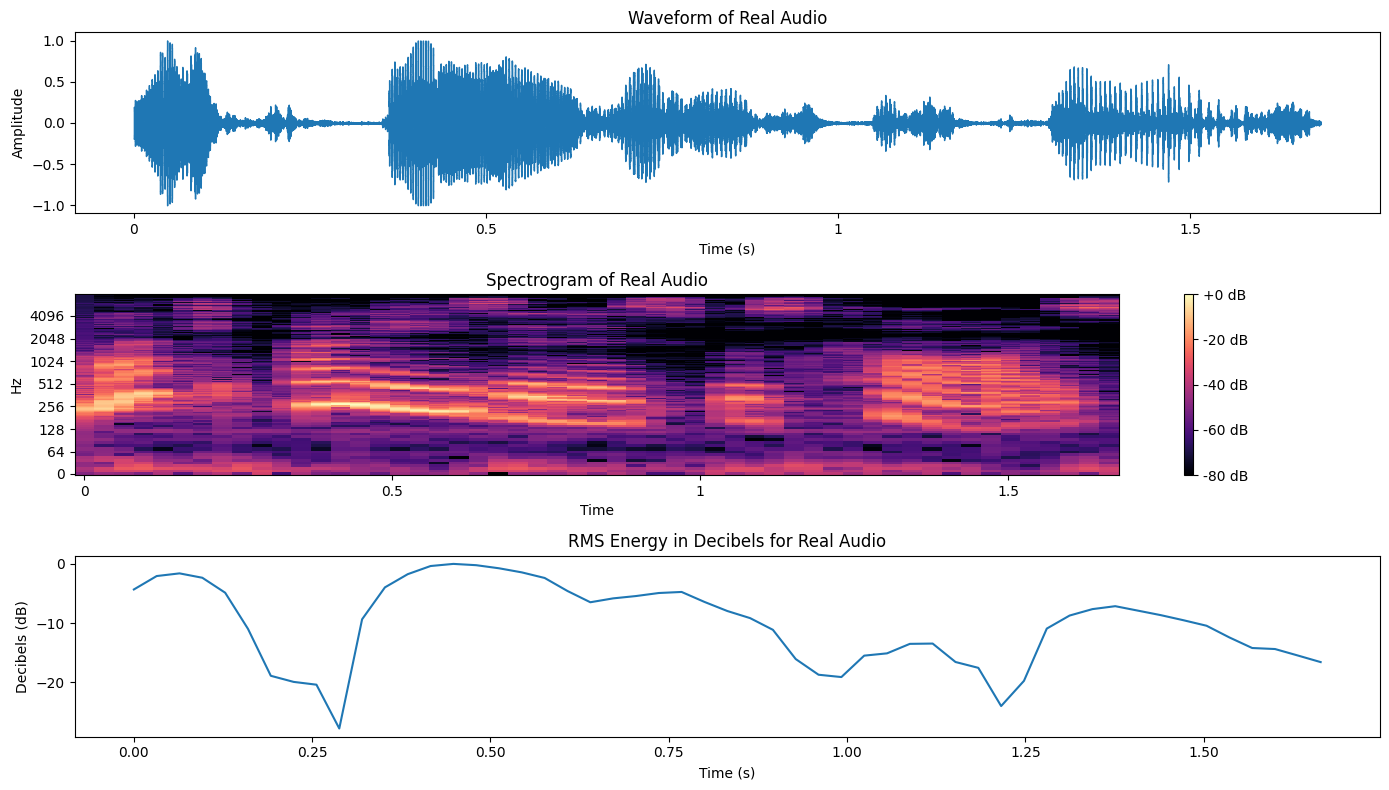

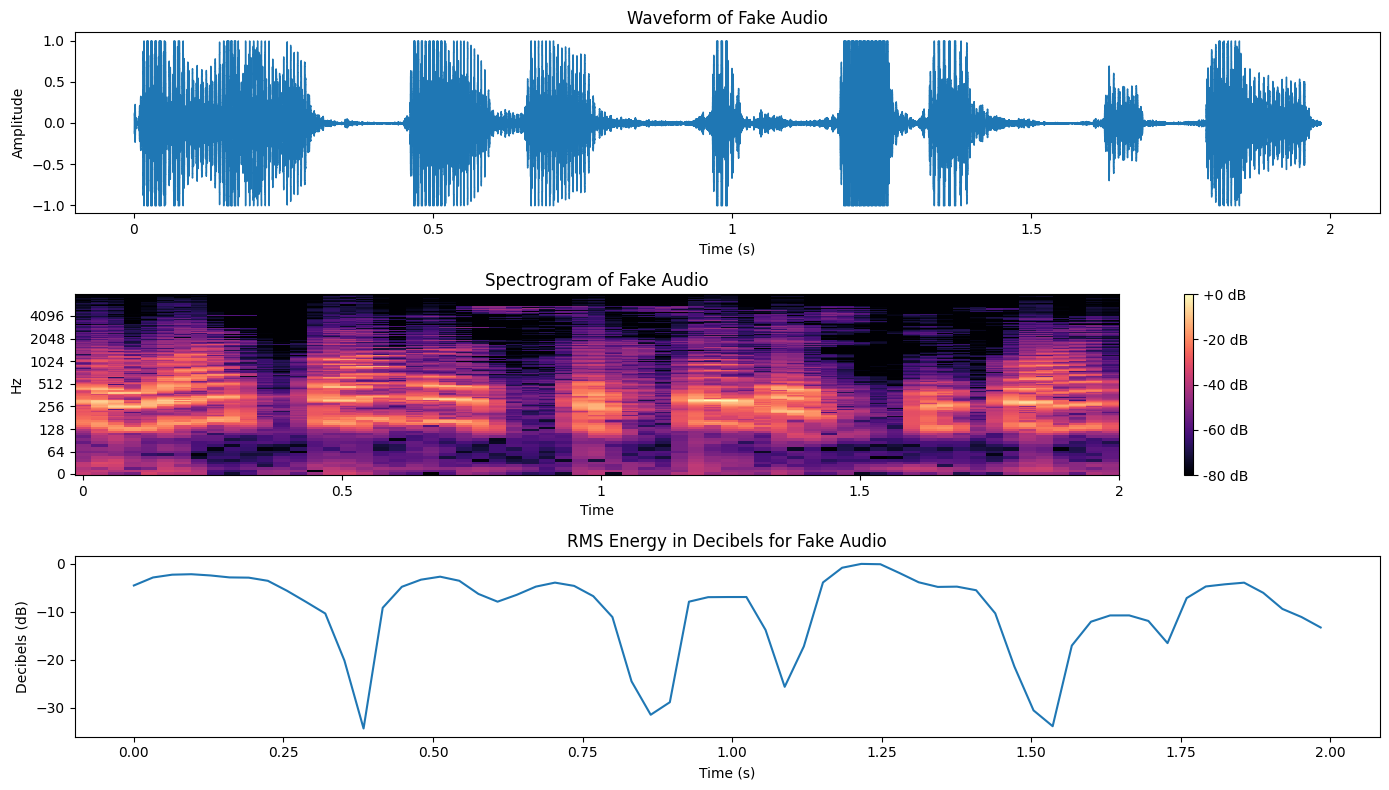

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the real and fake audio files
real_audio_path = r'for-rerec\for-rerecorded\real\recording6449.wav_norm_mono.wav'
fake_audio_path = r'for-rerec\for-rerecorded\fake\recording6445.wav_norm_mono.wav'

# Load the real audio file
real_audio, sr_real = librosa.load(real_audio_path, sr=None)

# Load the fake audio file
fake_audio, sr_fake = librosa.load(fake_audio_path, sr=None)

# Function to plot the spectrogram and decibel for an audio signal
def plot_audio_visualizations(audio_signal, sample_rate, title):
    plt.figure(figsize=(14, 8))

    # Plot waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(audio_signal, sr=sample_rate)
    plt.title(f'Waveform of {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot Spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_signal)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {title}')

    # Plot decibel (dB) over time
    plt.subplot(3, 1, 3)
    rms = librosa.feature.rms(y=audio_signal)[0]
    times = librosa.times_like(rms, sr=sample_rate)
    plt.plot(times, librosa.amplitude_to_db(rms, ref=np.max), label='RMS Energy (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Decibels (dB)')
    plt.title(f'RMS Energy in Decibels for {title}')

    plt.tight_layout()
    plt.show()

# Visualize Real Audio
plot_audio_visualizations(real_audio, sr_real, 'Real Audio')

# Visualize Fake Audio
plot_audio_visualizations(fake_audio, sr_fake, 'Fake Audio')


In [1]:
import os
import librosa
import numpy as np

# Function to extract Mel-spectrograms from audio
def extract_mel_spectrogram(file_path, n_mels=128, duration=3, sample_rate=22050):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        audio = librosa.util.fix_length(audio, size=duration * sample_rate)

        # Convert to Mel-spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

        return log_mel_spectrogram
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Return None for failed files

# Load dataset paths and labels
def load_dataset(data_dir):
    labels = []
    mel_spectrograms = []

    for label in ['real', 'fake']:
        folder = os.path.join(data_dir, label)
        
        if not os.path.exists(folder):
            print(f"Warning: Folder {folder} not found, skipping...")
            continue

        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            
            if not os.path.isfile(file_path):  # Skip if not a valid file
                print(f"Skipping {file_path}, not a regular file.")
                continue

            mel_spec = extract_mel_spectrogram(file_path)
            if mel_spec is not None:  # Skip if extraction failed
                mel_spectrograms.append(mel_spec)
                labels.append(0 if label == 'real' else 1)

    return np.array(mel_spectrograms), np.array(labels)

# Example: loading the training data
train_data_dir = r'for-rerec\for-rerecorded'  # Use raw string to avoid escape issues
X, y = load_dataset(train_data_dir)


In [ ]:
# 4. Check Class Distribution (Data Imbalance)
unique, counts = np.unique(y, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 6613, 1: 6655}


In [ ]:
# 5. Reshape Data for CNN
if X.size > 0:
    X = X[..., np.newaxis]  # Ensure shape (num_samples, height, width, 1)
    print(f"Loaded {len(X)} samples successfully!")
else:
    print("No valid audio files found!")
    exit()

Loaded 13268 samples successfully!


In [4]:
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

Dataset shape: (13268, 128, 130, 1), Labels shape: (13268,)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers

# CNN model
def build_cnn_model(input_shape):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))  # Reduced dropout
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Model summary
input_shape = (128, 130, 1)  # Adjust shape to match Mel-spectrogram size
model = build_cnn_model(input_shape)
model.summary()






Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 126, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 62, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 62, 64)        256       
 chNormalization)                                                
                                                     

In [7]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
# Split into training (70%), validation (20%), and test (10%)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 10% test

#Handle Class Imbalance using Oversampling
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train.reshape(len(X_train), -1), y_train)
X_train_resampled = X_train_resampled.reshape(-1, 128, 130, 1)  # Reshape back for CNN

# Compute Class Weights (Alternative to Oversampling)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
# Print Label Distribution Before & After Oversampling
unique_before, counts_before = np.unique(y_train, return_counts=True)
unique_after, counts_after = np.unique(y_train_resampled, return_counts=True)

print(f"🔹 Original Training Label Distribution: {dict(zip(unique_before, counts_before))}")
print(f"🔹 Resampled Training Label Distribution: {dict(zip(unique_after, counts_after))}")

🔹 Original Training Label Distribution: {0: 4606, 1: 4681}
🔹 Resampled Training Label Distribution: {0: 4681, 1: 4681}


In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
# Split into training (70%), validation (20%), and test (10%)

# Early Stopping: Stop training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # Track validation loss
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Model Checkpoint: Save the best model during training
model_checkpoint = ModelCheckpoint(
    "best_model.h5",  # Save the best model
    monitor="val_loss",
    save_best_only=True,  # Only save when val_loss improves
    verbose=1
)

# Learning rate decay
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train with class weights and learning rate decay
history = model.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=32, validation_data=(X_val, y_val),
                    class_weight=class_weights_dict, callbacks=[early_stopping, model_checkpoint, lr_scheduler])
# Load the best model saved by ModelCheckpoint
model = load_model("best_model.h5")

# Evaluate on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Best Model Validation Accuracy: {val_acc * 100:.2f}%")

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Best Model Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/30
293/293 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.8478
Epoch 1: val_loss improved from inf to 0.35263, saving model to best_model.h5
293/293 [==============================] - 58s 199ms/step - loss: 0.4715 - accuracy: 0.8478 - val_loss: 0.3526 - val_accuracy: 0.8976 - lr: 5.0000e-04
Epoch 2/30


c:\Users\ntrst\Downloads\RESOLUTE_AI\fastapi\newenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


293/293 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.9211
Epoch 2: val_loss did not improve from 0.35263
293/293 [==============================] - 62s 210ms/step - loss: 0.3135 - accuracy: 0.9211 - val_loss: 0.3943 - val_accuracy: 0.8470 - lr: 5.0000e-04
Epoch 3/30
293/293 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9537
Epoch 3: val_loss did not improve from 0.35263
293/293 [==============================] - 57s 193ms/step - loss: 0.2342 - accuracy: 0.9537 - val_loss: 0.3583 - val_accuracy: 0.9074 - lr: 5.0000e-04
Epoch 4/30
293/293 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9624
Epoch 4: val_loss improved from 0.35263 to 0.15162, saving model to best_model.h5
293/293 [==============================] - 57s 195ms/step - loss: 0.1990 - accuracy: 0.9624 - val_loss: 0.1516 - val_accuracy: 0.9850 - lr: 5.0000e-04
Epoch 5/30
293/293 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.972

In [12]:
# Load the best model saved by ModelCheckpoint
model = load_model("best_model.h5")

# Evaluate on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Best Model Validation Accuracy: {val_acc * 100:.2f}%")

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Best Model Test Accuracy: {test_acc * 100:.2f}%")

84/84 [==============================] - 4s 50ms/step - loss: 0.0622 - accuracy: 0.9948
Best Model Validation Accuracy: 99.48%
42/42 [==============================] - 2s 49ms/step - loss: 0.0742 - accuracy: 0.9916
Best Model Test Accuracy: 99.16%


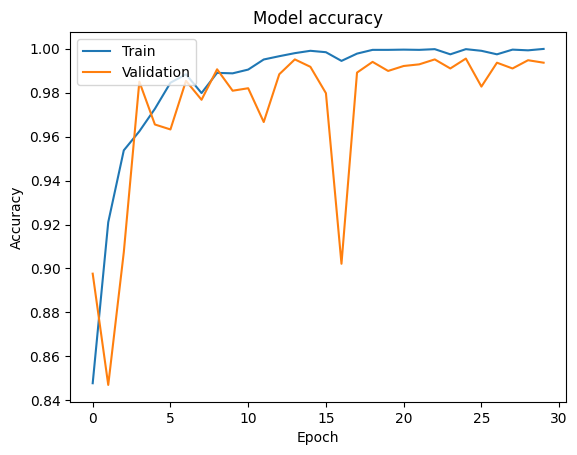

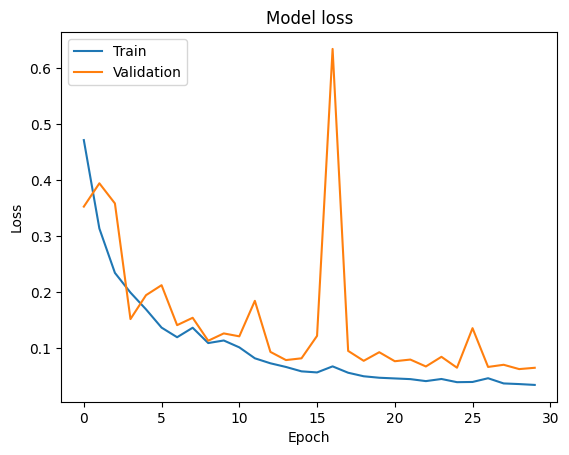

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
# Save the model
model.save('for_rerec_cnn_model.h5')

c:\Users\ntrst\Downloads\RESOLUTE_AI\fastapi\newenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
from sklearn.metrics import classification_report
import numpy as np

# Get model predictions on the test set
y_pred_probs = model.predict(X_test)  # Predict probabilities

# Convert probabilities to class labels (assuming softmax activation)
y_pred = (y_pred_probs >= 0.5).astype(int)  # ✅ Convert probabilities to 0 or 1

# Generate and print the classification report
print(classification_report(y_test, y_pred))


42/42 [==============================] - 2s 47ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       684
           1       0.99      1.00      0.99       630

    accuracy                           0.99      1314
   macro avg       0.99      0.99      0.99      1314
weighted avg       0.99      0.99      0.99      1314



42/42 [==============================] - 2s 47ms/step


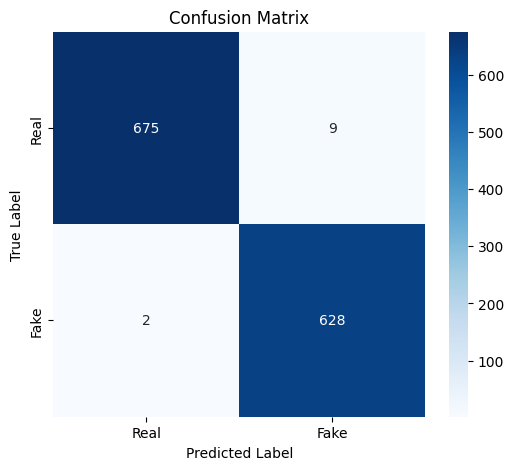

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions on test set
y_pred_probs = model.predict(X_test)  # Predict probabilities
y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
